In [2]:
import csv
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import umap.umap_ as umap
from scipy.linalg import eigh as largest_eigh
import sklearn

from scipy.linalg import orthogonal_procrustes

In [3]:
HiC_Exc = pd.read_csv("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/SAI_results/single_cell_eigens/Exc/eigen.txt", sep='\t', names=["chr", "start", "end", "compartment", "eigen"], index_col=False)
bin_df = pd.read_csv("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/gap.blacklist.hg38.1000000.4col.autosomal.bed", sep='\t', names=["chr","start","end","name"])
delete_bins = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/delete_bins.npy")
bin_df_new = bin_df.drop(delete_bins).reset_index(drop=True)

In [4]:
bin_df_new[bin_df_new.chr=="chr2"].loc[380:390,:]

,chr,start,end,name
380,chr2,195000000,196000000,chr2_196
381,chr2,196000000,197000000,chr2_197
382,chr2,197000000,198000000,chr2_198
383,chr2,198000000,199000000,chr2_199
384,chr2,199000000,200000000,chr2_200
385,chr2,200000000,201000000,chr2_201
386,chr2,201000000,202000000,chr2_202
387,chr2,202000000,203000000,chr2_203
388,chr2,203000000,204000000,chr2_204
389,chr2,204000000,205000000,chr2_205


In [5]:
bin_df_new[bin_df_new.chr=="chr10"]

,chr,start,end,name
1371,chr10,1000000,2000000,chr10_2
1372,chr10,2000000,3000000,chr10_3
1373,chr10,3000000,4000000,chr10_4
1374,chr10,4000000,5000000,chr10_5
1375,chr10,5000000,6000000,chr10_6
1376,chr10,6000000,7000000,chr10_7
1377,chr10,7000000,8000000,chr10_8
1378,chr10,8000000,9000000,chr10_9
1379,chr10,9000000,10000000,chr10_10
1380,chr10,10000000,11000000,chr10_11


In [6]:
bulk_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Bulk-ATAC-seq/hfc/feature.npy")
CON_Exc_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Exc/raw/feature.npy")
CON_Mic_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Mic/raw/feature.npy")

In [1]:
bulk_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Bulk-ATAC-seq/hfc/Embedding/corr_0_1_VERSE_32.npy")
CON_Exc_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Exc/20_metacell/Embedding/corr_0_1_VERSE_32.npy")
CON_Mic_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Mic/20_metacell/Embedding/corr_0_1_VERSE_32.npy")

NameError: name 'np' is not defined

In [8]:
bulk_eigen = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Bulk-ATAC-seq/hfc/first_eigenvector_dzh.npy")
CON_Exc_eigen = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Exc/20_metacell/first_eigenvector.npy")
CON_Mic_eigen = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Mic/20_metacell/first_eigenvector.npy")

In [9]:
R, _ = orthogonal_procrustes(CON_Exc_emb, CON_Mic_emb)
transfer_Exc = CON_Exc_emb @ R

/home/zihend1/.conda/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


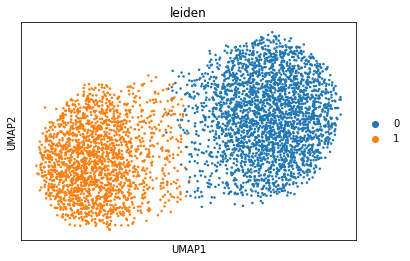

In [10]:
embedding = np.vstack((transfer_Exc, CON_Mic_emb))
# embedding = np.vstack((CON_Exc_emb, CON_Mic_emb))
adata = ad.AnnData(embedding)
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X')
sc.tl.leiden(adata,resolution=0.3)
sc.tl.umap(adata)
adata.obs['eigen'] = np.vstack((CON_Exc_eigen, CON_Mic_eigen))
fig = sc.pl.umap(adata, color='leiden', return_fig=True)
# fig = sc.pl.umap(adata, color='eigen', return_fig=True)
# fig.savefig('before_alignment.eps',dpi=1000,format='eps')

In [11]:
pos = np.array(adata.obsm['X_umap'])
color_array = np.array(adata.obs["leiden"], dtype=np.int32)
total_feature = np.hstack((np.sum(CON_Exc_feature, axis=0), np.sum(CON_Mic_feature, axis=0)))
np.sum(total_feature[np.where(color_array==1)]), np.sum(total_feature[np.where(color_array==0)])

(141397435, 119962657)

In [27]:
key_point = 1387
start = 1371
end = 1496
# background = True
background = False

In [21]:
color_list = []
size_list = []
linewidths_list = []
for i in range(color_array.shape[0]):
    if (i>=start and i<=end) or (i>=start+2329 and i<=end+2329):
        size_list.append(30)
        linewidths_list.append(2)
        if color_array[i] == 1:
            color_list.append("#ad5247")
        else:
            color_list.append("#6e896a")
    else:
        size_list.append(5)
        linewidths_list.append(1)
        color_list.append("#C0C0C0")

In [30]:
# edgecolors_list = color_list
# non_color_list = ['none' for i in range(color_array.shape[0])]
# for i in range(color_array.shape[0]):
#     if i<2329:
#         plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="o", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
#     else:
#         plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="^", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
# # plt.savefig('CON_Exc_chr10.eps',dpi=1000,format='eps')
# # plt.savefig('CON_Exc_background_chr10.eps',dpi=1000,format='eps')
# plt.show()

1387 #6e896a 8.399664 8.0872135
3716 #ad5247 3.0334387 5.9147444


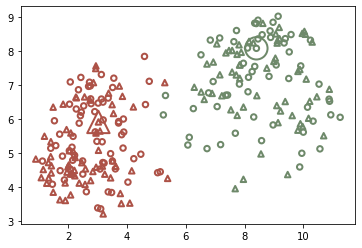

In [29]:
edgecolors_list = color_list
non_color_list = ['none' for i in range(color_array.shape[0])]

for i in range(color_array.shape[0]):
    if i<2329:
        if background:
            if (i<start or i>end):
                plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="o", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
        else:
            if (i>=start and i<=end):
                plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="o", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                if i==key_point:
                    print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                    plt.scatter(pos[i,0], pos[i,1], s=500, color=non_color_list[i], marker="o", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
    else:
        if background:
            if (i<start+2329 or i>end+2329):
                plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="^", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
        else:
            if (i>=start+2329 and i<=end+2329):
                plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="^", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                if i==key_point+2329:
                    print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                    plt.scatter(pos[i,0], pos[i,1], s=500, color=non_color_list[i], marker="^", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])

plt.savefig('CON_Exc_chr10.eps',dpi=1000,format='eps')
# plt.savefig('CON_Exc_background_chr10.eps',dpi=1000,format='eps')
plt.show()

In [38]:
key_point = 384
start = 218
end = 421
# background = True
background = False

In [39]:
color_list = []
size_list = []
linewidths_list = []
for i in range(color_array.shape[0]):
    if (i>=start and i<=end) or (i>=start+2329 and i<=end+2329):
        size_list.append(30)
        linewidths_list.append(2)
        if color_array[i] == 1:
            color_list.append("#ad5247")
        else:
            color_list.append("#6e896a")
    else:
        size_list.append(5)
        linewidths_list.append(1)
        color_list.append("#C0C0C0")

384 #ad5247 4.9258766 5.7847786
2713 #6e896a 10.117546 5.734673


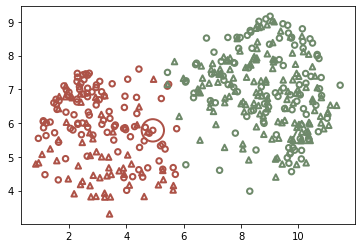

In [40]:
edgecolors_list = color_list
non_color_list = ['none' for i in range(color_array.shape[0])]

for i in range(color_array.shape[0]):
    if i<2329:
        if background:
            if (i<start or i>end):
                plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="o", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
        else:
            if (i>=start and i<=end):
                plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="o", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                if i==key_point:
                    print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                    plt.scatter(pos[i,0], pos[i,1], s=500, color=non_color_list[i], marker="o", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
    else:
        if background:
            if (i<start+2329 or i>end+2329):
                plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="^", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
        else:
            if (i>=start+2329 and i<=end+2329):
                plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="^", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                if i==key_point+2329:
                    print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                    plt.scatter(pos[i,0], pos[i,1], s=500, color=non_color_list[i], marker="^", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])

plt.savefig('CON_Exc_chr2.eps',dpi=1000,format='eps')
# plt.savefig('CON_Exc_background_chr2.eps',dpi=1000,format='eps')
plt.show()

In [61]:
temp = CON_Exc_emb 
CON_Exc_emb = CON_Mic_emb
CON_Mic_emb = temp

In [62]:
R, _ = orthogonal_procrustes(CON_Exc_emb, CON_Mic_emb)
transfer_Exc = CON_Exc_emb @ R

In [63]:
d = transfer_Exc[384]-CON_Mic_emb[384]

In [64]:
np.sqrt(np.sum(d**2))

2.2564256

In [65]:
d = transfer_Exc[1387]-CON_Mic_emb[1387]

In [66]:
np.sqrt(np.sum(d**2))

2.428372

In [59]:
d = transfer_Exc[1371+25]-CON_Mic_emb[1371+25]

In [60]:
np.sqrt(np.sum(d**2))

2.8835087

In [55]:
d = (transfer_Exc - CON_Mic_emb)

In [56]:
ddd = -np.sqrt(np.sum(d**2, axis=1))

In [57]:
ddd

array([-1.5644426, -2.178739 , -2.0634568, ..., -2.5967855, -1.9955646,
       -2.3658512], dtype=float32)

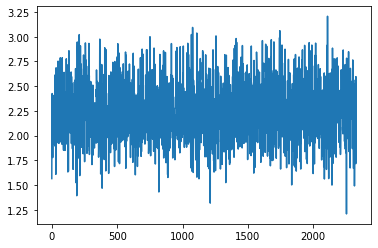

In [58]:
plt.plot(-ddd)

In [48]:
ddd.sort()

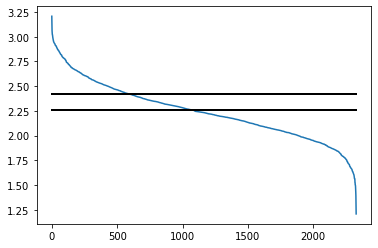

In [53]:
plt.plot(-ddd)
plt.plot([0, 2328], [2.26, 2.26], color='k', linestyle='-', linewidth=2)
plt.plot([0, 2328], [2.42, 2.42], color='k', linestyle='-', linewidth=2)
plt.savefig('rank_l2.eps', dpi=1000, format='eps')